<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/our_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import cv2
import keras
import os
from zipfile import ZipFile
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import tensorflow as tf
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.applications.resnet50 import preprocess_input


In [6]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Data Preparation

In [7]:
 #Unzipping the dataset file combined_faces.zip

combined_faces_zip_path = "/content/drive/My Drive/Dataset/Dataset2/combined_dataset/combined_faces.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces.zip')

Done unzipping combined_faces.zip


In [8]:
# Unzipping the dataset file combined_faces.zip

combined_faces_zip_path =  "/content/drive/My Drive/Dataset/Dataset2/combined_dataset/combined_faces_train_augmented.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces_train_augmented.zip')

Done unzipping combined_faces_train_augmented.zip


In [9]:
import pandas as pd
train_aug_df = pd.read_csv( "/content/drive/My Drive/Dataset/Dataset2/combined_dataset/images_filenames_labels_train_augmented.csv")
test_df = pd.read_csv("/content/drive/My Drive/Dataset/Dataset2/combined_dataset/images_filenames_labels_test.csv")


In [10]:
train_aug_df.head()

,filename,age
0,/content/content/combined_faces_train_augmente...,43
1,/content/content/combined_faces_train_augmente...,71
2,/content/content/combined_faces_train_augmente...,6
3,/content/content/combined_faces_train_augmente...,18
4,/content/content/combined_faces_train_augmente...,25


In [11]:
test_df.head()

,filename,age
0,/content/content/combined_faces/8_163.jpg,8
1,/content/content/combined_faces/38_66.jpg,38
2,/content/content/combined_faces/40_177.jpg,40
3,/content/content/combined_faces/36_267.jpg,36
4,/content/content/combined_faces/8_349.jpg,8


In [12]:
# Define age ranges
age_ranges = [(1, 2), (3, 9), (10, 20), (21, 27), (28, 45), (46, 65), (66, 116)]

In [13]:
def categorize_age(age):
    for range_name, (start, end) in enumerate(age_ranges):
        if start <= age <= end:
            return range_name
    return None

In [14]:
train_aug_df['target'] = train_aug_df['age'].map(categorize_age)
test_df['target'] = test_df['age'].map(categorize_age)

In [15]:
train_aug_df.head()

,filename,age,target
0,/content/content/combined_faces_train_augmente...,43,4
1,/content/content/combined_faces_train_augmente...,71,6
2,/content/content/combined_faces_train_augmente...,6,1
3,/content/content/combined_faces_train_augmente...,18,2
4,/content/content/combined_faces_train_augmente...,25,3


In [16]:
test_df.head()

,filename,age,target
0,/content/content/combined_faces/8_163.jpg,8,1
1,/content/content/combined_faces/38_66.jpg,38,4
2,/content/content/combined_faces/40_177.jpg,40,4
3,/content/content/combined_faces/36_267.jpg,36,4
4,/content/content/combined_faces/8_349.jpg,8,1


In [17]:
train_aug_df.shape

(234400, 3)

In [18]:
test_df.shape

(10046, 3)

In [19]:
# Converting the filenames and target class labels into lists for augmented train and test datasets.

train_aug_filenames_list = list(train_aug_df['filename'])
train_aug_labels_list = list(train_aug_df['target'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

In [20]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_labels_tensor = tf.constant(train_aug_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [21]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):

    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [224, 224])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [22]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_aug_dataset = train_aug_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

In [23]:
# Defining the architecture of the sequential neural network.

final_cnn = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
final_cnn.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
final_cnn.add(Dense(132, activation='relu'))

# Output layer with 7 nodes (equal to the no. of classes).
final_cnn.add(Dense(7, activation='softmax'))

final_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d (Average  (None, 99, 99, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_1 (Avera  (None, 48, 48, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_2 (Avera  (None, 23, 23, 128)       0

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN1_A3_FineTuned3.h5',  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,
    save_best_only=True,  # Only save the best model
    mode='max'  # Mode to determine best (maximizing validation accuracy)
)

In [25]:

# Compiling the above created CNN architecture.

final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
# Train your model
history = final_cnn.fit(train_aug_dataset, validation_data=test_dataset, epochs=60,batch_size=512, callbacks=[early_stopping,model_checkpoint])

Epoch 1/60
458/458 [==============================] - ETA: 0s - loss: 1.8167 - accuracy: 0.3194
Epoch 1: val_accuracy improved from -inf to 0.37806, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN1_A3_FineTuned3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


458/458 [==============================] - 189s 363ms/step - loss: 1.8167 - accuracy: 0.3194 - val_loss: 1.5885 - val_accuracy: 0.3781
Epoch 2/60
458/458 [==============================] - ETA: 0s - loss: 1.4926 - accuracy: 0.3994
Epoch 2: val_accuracy improved from 0.37806 to 0.44426, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN1_A3_FineTuned3.h5
458/458 [==============================] - 150s 326ms/step - loss: 1.4926 - accuracy: 0.3994 - val_loss: 1.3595 - val_accuracy: 0.4443
Epoch 3/60
458/458 [==============================] - ETA: 0s - loss: 1.3316 - accuracy: 0.4585
Epoch 3: val_accuracy improved from 0.44426 to 0.51404, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN1_A3_FineTuned3.h5
458/458 [==============================] - 150s 327ms/step - loss: 1.3316 - accuracy: 0.4585 - val_loss: 1.1835 - val_accuracy: 0.5140
Epoch 4/60
458/458 [==============================] - ETA: 0s - loss: 1.1734 - accuracy: 0.5154
Epoch

In [27]:
# Save the training history
history_dict = history.history

# Plot the training and validation metrics
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

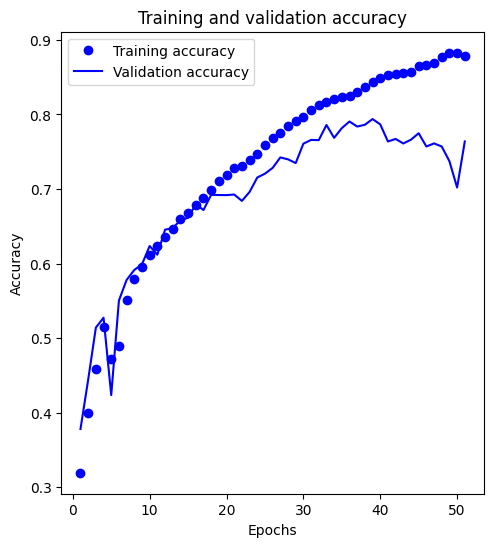

In [28]:
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

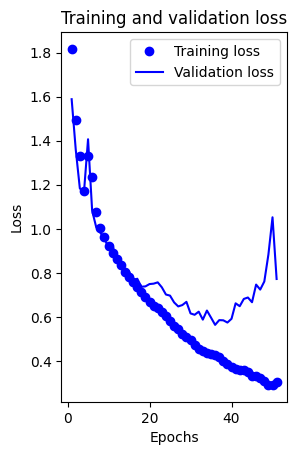

In [29]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [31]:
# Load the best model
final_cnn.load_weights('/content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN1_A3_FineTuned3.h5')
# Evaluate the model
# Evaluate the model on the validation dataset
val_loss, val_accuracy = final_cnn.evaluate(test_dataset, verbose=1)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


20/20 [==============================] - 3s 135ms/step - loss: 0.5746 - accuracy: 0.7938
Validation Loss: 0.5745709538459778
Validation Accuracy: 0.7938482761383057


In [32]:
representative_ages = [np.mean(rng) for rng in age_ranges]

In [33]:
# Convert predictions and true labels back to representative ages
y_pred = final_cnn.predict(test_dataset)
y_pred_ages = [representative_ages[np.argmax(pred)] for pred in y_pred]

# Since val_labels is one-hot encoded, convert it to a numpy array and then to representative ages
val_labels_np = np.concatenate([y for x, y in test_dataset], axis=0)
y_true_ages = [representative_ages[np.argmax(true)] for true in val_labels_np]

# Calculate MAE
mae = np.mean(np.abs(np.array(y_true_ages) - np.array(y_pred_ages)))
print(f'Test MAE: {mae:.2f}')

20/20 [==============================] - 3s 133ms/step
Test MAE: 3.56


In [34]:
# Calculate MAE for each age range
age_range_mae = {}
for idx, age_range in enumerate(age_ranges):
    # Get the indices for the current age range
    range_indices = [i for i, age in enumerate(y_true_ages) if age_range[0] <= age <= age_range[1]]

    if range_indices:
        # Calculate MAE for the current age range
        y_true_range = np.array([y_true_ages[i] for i in range_indices])
        y_pred_range = np.array([y_pred_ages[i] for i in range_indices])

        mae = np.mean(np.abs(y_true_range - y_pred_range))
        age_range_mae[age_range] = mae

# Print MAE for each age range
for age_range, mae in age_range_mae.items():
    print(f"Age Range {age_range}: MAE = {mae:.2f}")

Age Range (1, 2): MAE = 0.42
Age Range (3, 9): MAE = 1.19
Age Range (10, 20): MAE = 3.18
Age Range (21, 27): MAE = 3.19
Age Range (28, 45): MAE = 3.50
Age Range (46, 65): MAE = 5.14
Age Range (66, 116): MAE = 7.99


In [35]:
# Make predictions on the validation dataset
predictions = final_cnn.predict(test_dataset)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Since val_labels is one-hot encoded, convert it to class labels
# Note: val_labels_np should be a concatenation of one-hot encoded labels from val_dataset
val_labels_np = np.concatenate([y for x, y in test_dataset], axis=0)  # Flatten the labels
true_classes = np.argmax(val_labels_np, axis=1)

# Optionally, print some of the predicted and true class labels to verify
print("Sample predicted classes:", predicted_classes[:10])
print("Sample true classes:", true_classes[:10])

20/20 [==============================] - 3s 133ms/step
Sample predicted classes: [1 4 4 4 1 4 4 6 1 6]
Sample true classes: [1 4 4 4 1 4 4 6 1 6]


In [36]:
# Calculate classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.79
Precision: 0.80
Recall: 0.79
F1-score: 0.79


In [37]:
# Calculate accuracy for each class
class_accuracies = {}
for idx, (start, end) in enumerate(age_ranges):
    # Filter predictions and true labels for the current class
    mask = (true_classes == idx)
    accuracy = accuracy_score(true_classes[mask], predicted_classes[mask])
    class_accuracies[f'{start}-{end}'] = accuracy

In [38]:
# Print accuracy for each class
for age_range, accuracy in class_accuracies.items():
    print(f'Accuracy for age range {age_range}: {accuracy:.2f}')

Accuracy for age range 1-2: 0.97
Accuracy for age range 3-9: 0.86
Accuracy for age range 10-20: 0.75
Accuracy for age range 21-27: 0.75
Accuracy for age range 28-45: 0.76
Accuracy for age range 46-65: 0.79
Accuracy for age range 66-116: 0.80


In [39]:
# Example metrics calculation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Detailed classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=[f'{start}-{end}' for start, end in age_ranges]))

# Confusion Matrix
print('\nConfusion Matrix:')
print(confusion_matrix(true_classes, predicted_classes))


Classification Report:
              precision    recall  f1-score   support

         1-2       0.93      0.97      0.95       958
         3-9       0.89      0.86      0.88       845
       10-20       0.83      0.75      0.79       941
       21-27       0.70      0.75      0.73      2007
       28-45       0.74      0.76      0.75      2807
       46-65       0.80      0.79      0.79      1679
      66-116       0.90      0.80      0.85       809

    accuracy                           0.79     10046
   macro avg       0.83      0.81      0.82     10046
weighted avg       0.80      0.79      0.79     10046


Confusion Matrix:
[[ 929   22    0    1    4    1    1]
 [  63  724   43   11    3    1    0]
 [   0   53  709  114   60    5    0]
 [   1    3   58 1502  429   14    0]
 [   2    3   34  458 2147  160    3]
 [   0    3    5   42  243 1320   66]
 [   2    1    1    7   10  144  644]]


20/20 [==============================] - 3s 134ms/step
Normalized confusion matrix


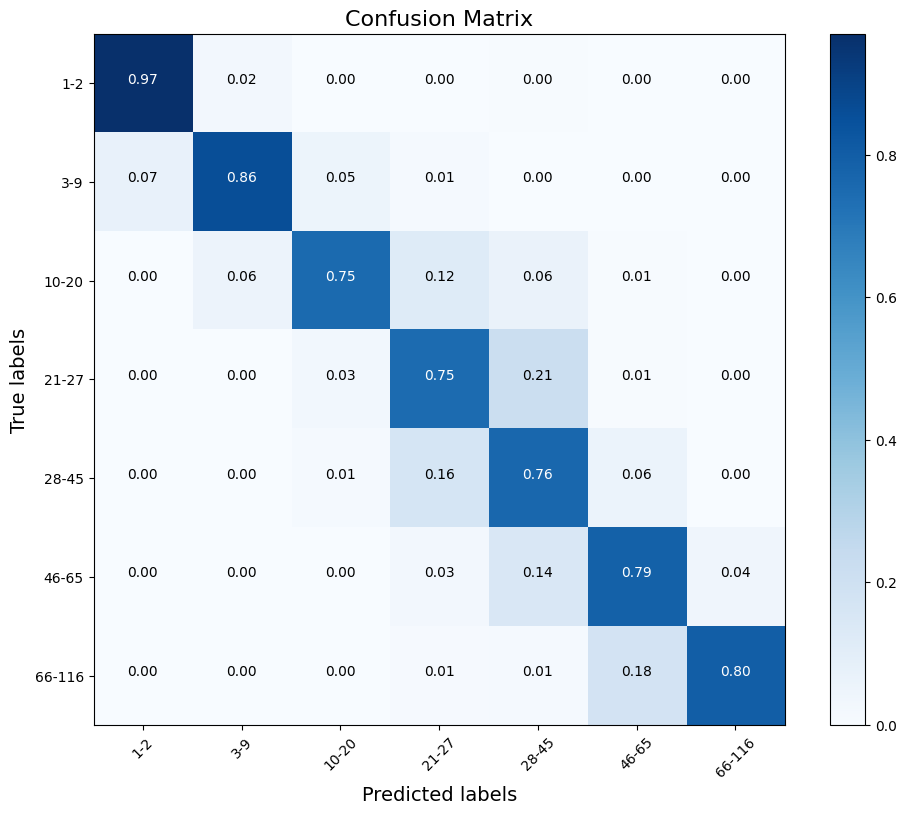

In [40]:
import itertools

# Define your function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

# Make predictions on the validation dataset
predictions = final_cnn.predict(test_dataset)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Since val_labels is one-hot encoded, convert it to class labels
val_labels_np = np.concatenate([y for x, y in test_dataset], axis=0)  # Flatten the labels
true_classes = np.argmax(val_labels_np, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Age range labels
age_range_labels = [f'{start}-{end}' for start, end in age_ranges]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(conf_matrix, classes=age_range_labels,normalize=True, title='Confusion Matrix')
plt.show()